In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def mean_imputation(df, target_cols, neighbor_cols):
    """Apply mean imputation using neighboring countries"""
    df_mean = df.copy()
    
    # Convert all relevant columns to numeric
    cols_to_convert = set()
    for target in target_cols:
        cols_to_convert.add(target)
        if target in neighbor_cols:
            cols_to_convert.update(neighbor_cols[target])
    
    for col in cols_to_convert:
        df_mean[col] = pd.to_numeric(df_mean[col].replace('-', np.nan), errors='coerce')
    
    # Apply mean imputation
    for target_col in target_cols:
        if target_col in neighbor_cols:
            mask_missing = df_mean[target_col].isna()
            neighbor_means = df_mean[neighbor_cols[target_col]].mean(axis=1)
            df_mean.loc[mask_missing, target_col] = neighbor_means[mask_missing]
    
    return df_mean

In [3]:
def plot_imputation_results(original_df, imputed_df, method_name, target_cols, gaps_dict):
    """Plot original vs imputed values for each gap"""
    
    figs = []
    
    for col in target_cols:
        # Convert data to numeric first
        original_df[col] = pd.to_numeric(original_df[col].replace('-', np.nan), errors='coerce')
        
        for gap_start, gap_end in gaps_dict[col]:
            # Convert dates to datetime
            vis_start = pd.to_datetime(gap_start) - pd.Timedelta(days=5)
            vis_end = pd.to_datetime(gap_end) + pd.Timedelta(days=5)
            
            mask = (original_df['Start date'] >= vis_start) & \
                   (original_df['Start date'] <= vis_end)
            
            # Skip if no data in visualization window
            if not any(mask):
                print(f"Skipping {col} gap {gap_start} to {gap_end} - No data in visualization window")
                continue
            
            fig, ax = plt.subplots(figsize=(15, 6))
            
            dates = original_df[mask]['Start date']
            original_data = original_df[mask][col]
            not_missing = ~original_data.isna()
            
            # Plot original data
            mask_diff = not_missing.astype(int).diff()
            break_points = mask_diff.ne(0).cumsum()
            
            for segment in break_points.unique():
                segment_mask = break_points == segment
                if not_missing[segment_mask].any():
                    ax.plot(dates[segment_mask], 
                           original_data[segment_mask],
                           'b-o', label='Original' if segment == break_points.iloc[0] else "", 
                           alpha=0.7)
            
            # Plot imputed values
            gap_start_dt = pd.to_datetime(gap_start)
            gap_end_dt = pd.to_datetime(gap_end)
            
            imputation_period = (dates >= gap_start_dt) & (dates <= gap_end_dt)
            
            # Find previous and next values if they exist
            prev_dates = dates[dates < gap_start_dt]
            next_dates = dates[dates > gap_end_dt]
            
            imputed_dates = dates[imputation_period]
            imputed_values = imputed_df.loc[imputation_period.index[imputation_period], col]
            
            # Add connecting points if they exist
            if len(prev_dates) > 0:
                prev_value_date = prev_dates.iloc[-1]
                prev_value = original_df.loc[original_df['Start date'] == prev_value_date, col].iloc[0]
                imputed_dates = pd.concat([pd.Series([prev_value_date]), imputed_dates])
                imputed_values = pd.concat([pd.Series([prev_value]), imputed_values])
            
            if len(next_dates) > 0:
                next_value_date = next_dates.iloc[0]
                next_value = original_df.loc[original_df['Start date'] == next_value_date, col].iloc[0]
                imputed_dates = pd.concat([imputed_dates, pd.Series([next_value_date])])
                imputed_values = pd.concat([imputed_values, pd.Series([next_value])])
            
            ax.plot(imputed_dates, imputed_values,
                   'r-o', label='Imputed Values', alpha=0.7)
            
            ax.set_title(f'{col} - {method_name}\nGap: {gap_start} to {gap_end}')
            ax.set_xlabel('Date')
            ax.set_ylabel('Price [€/MWh]')
            ax.legend()
            ax.grid(True)
            ax.tick_params(axis='x', rotation=45)
            
            plt.tight_layout()
            figs.append(fig)
    
    return figs

Imputed data saved to 'smard_mean_imputation.csv'


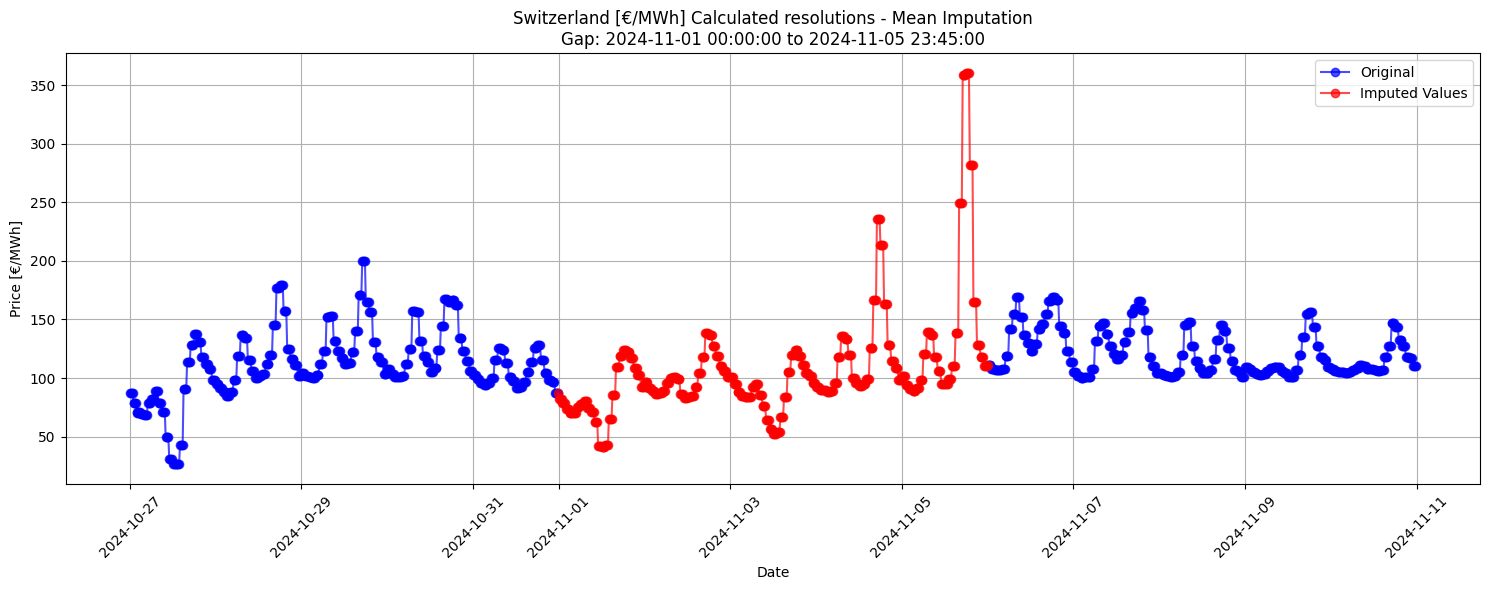

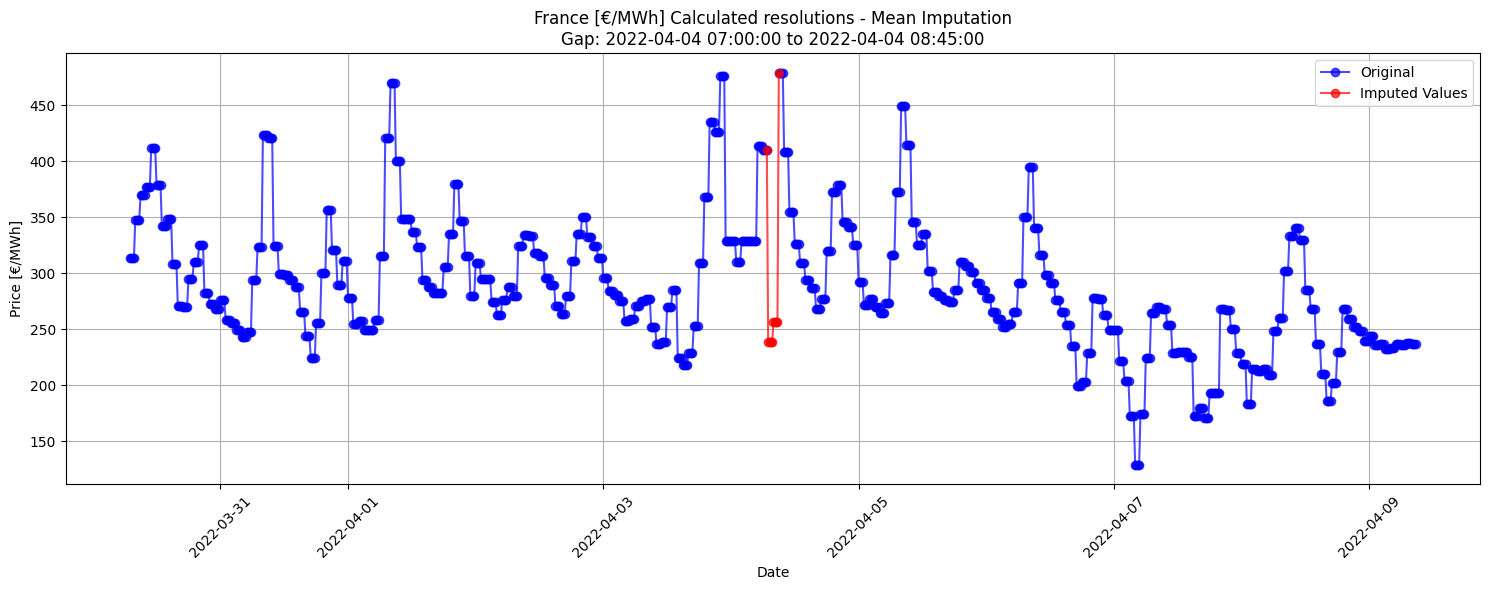

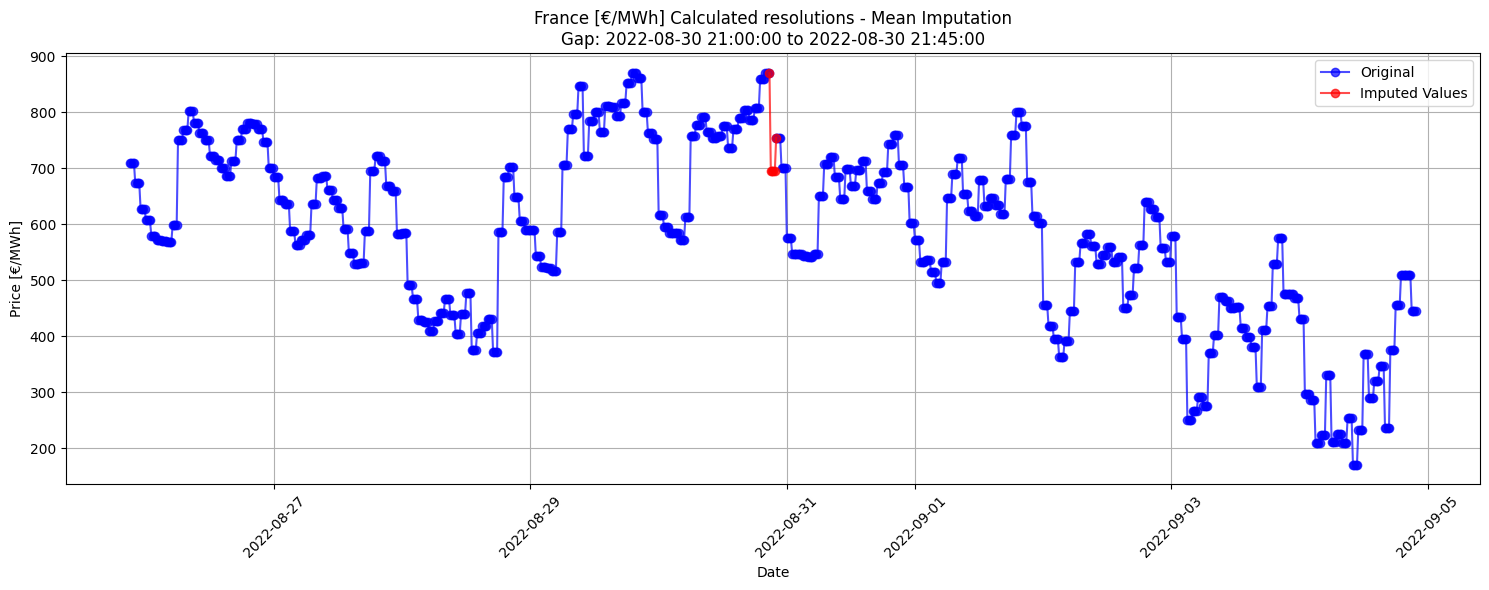

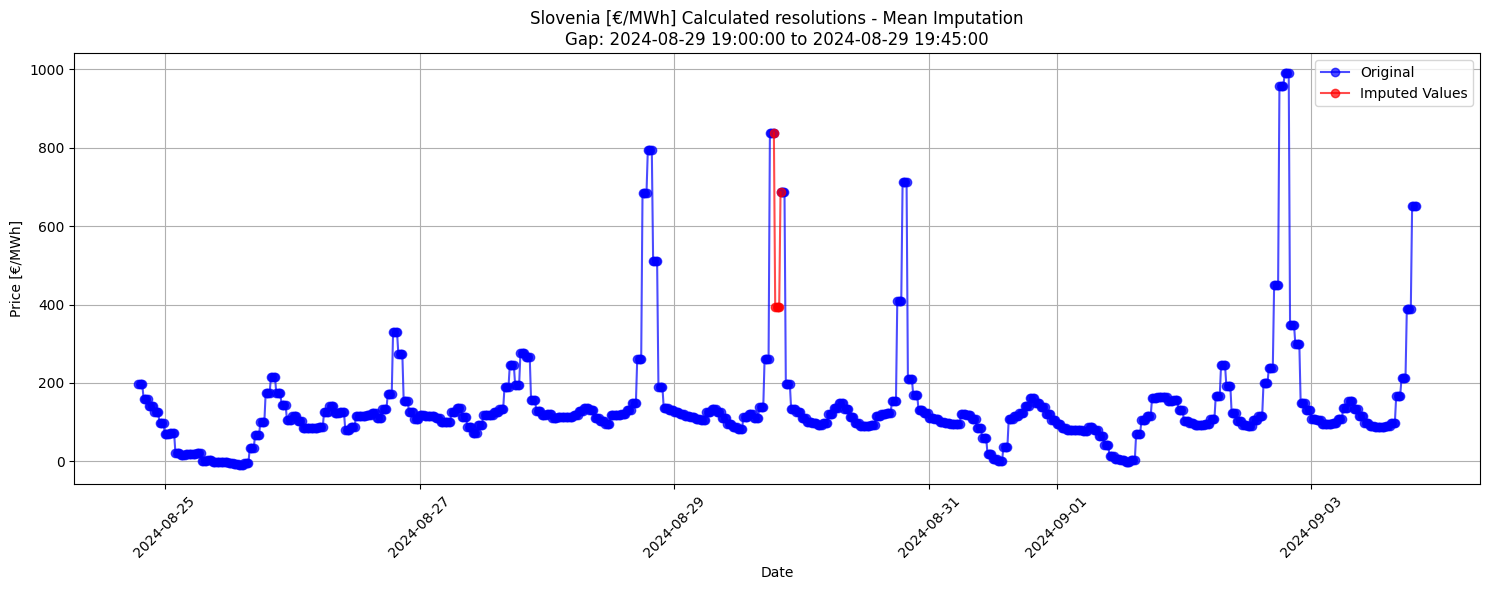

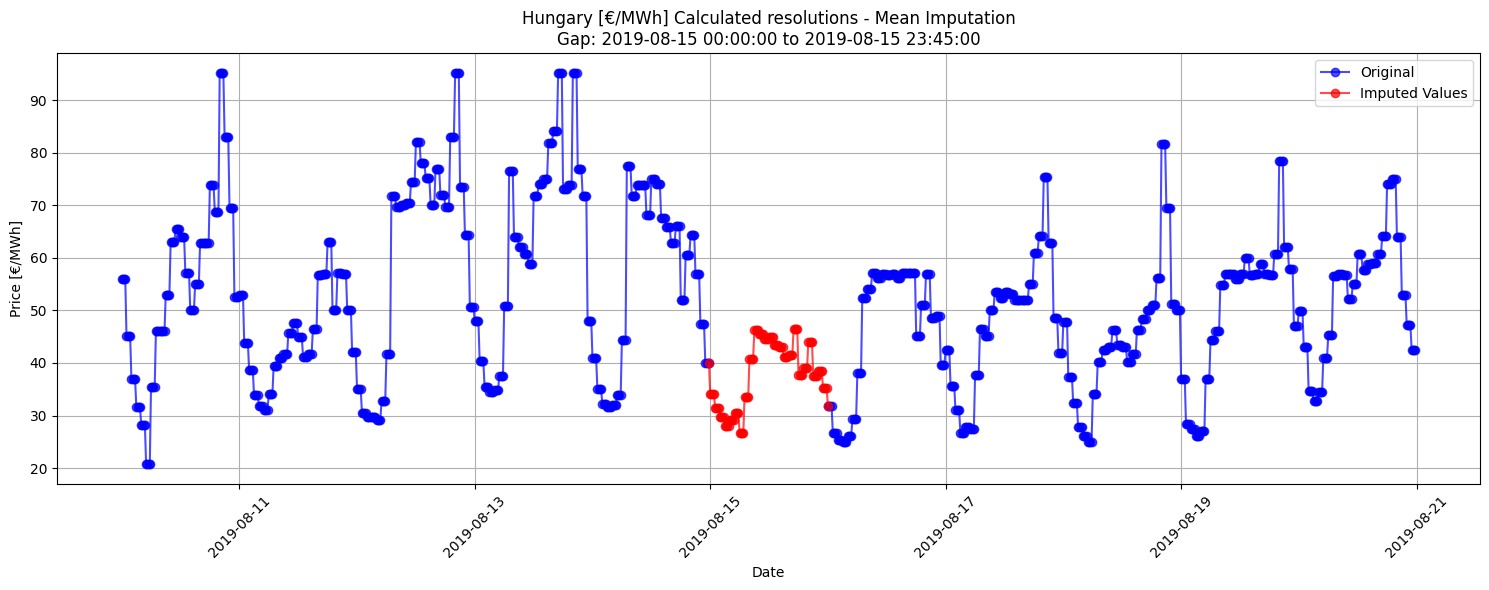

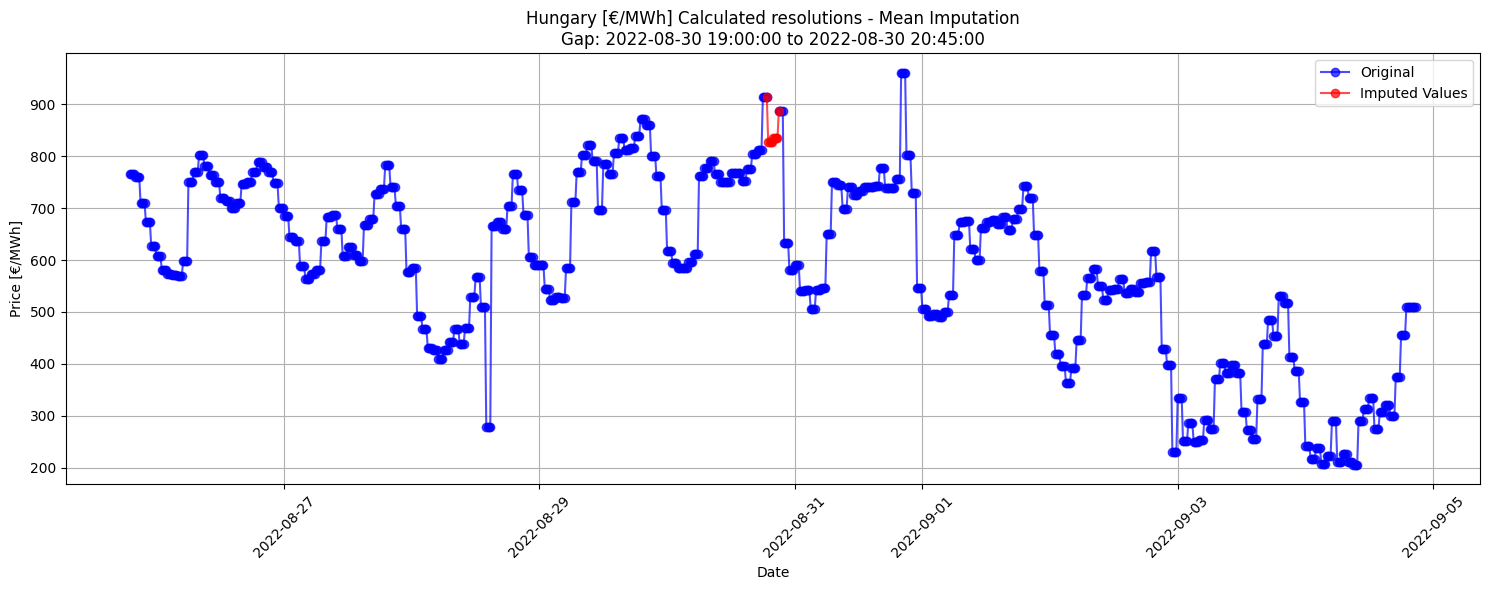

In [7]:
if __name__ == "__main__":
    # Define gaps for all countries
    gaps_dict = {
        'Switzerland [€/MWh] Calculated resolutions': [
            ('2024-11-01 00:00:00', '2024-11-05 23:45:00')
        ],
        'France [€/MWh] Calculated resolutions': [
            ('2022-04-04 07:00:00', '2022-04-04 08:45:00'),
            ('2022-08-30 21:00:00', '2022-08-30 21:45:00')
        ],
        'Slovenia [€/MWh] Calculated resolutions': [
            ('2024-08-29 19:00:00', '2024-08-29 19:45:00')
        ],
        'Hungary [€/MWh] Calculated resolutions': [
            ('2019-08-15 00:00:00', '2019-08-15 23:45:00'),
            ('2022-08-30 19:00:00', '2022-08-30 20:45:00')
        ]
    }

    # Define neighboring countries for each target
    neighbor_cols = {
        'Switzerland [€/MWh] Calculated resolutions': [
            'Germany/Luxembourg [€/MWh] Calculated resolutions',
            'France [€/MWh] Calculated resolutions',
            'Austria [€/MWh] Calculated resolutions'
        ],
        'France [€/MWh] Calculated resolutions': [
            'Germany/Luxembourg [€/MWh] Calculated resolutions',
            'Switzerland [€/MWh] Calculated resolutions',
            'Belgium [€/MWh] Calculated resolutions'
        ],
        'Slovenia [€/MWh] Calculated resolutions': [
            'Austria [€/MWh] Calculated resolutions',
            'Hungary [€/MWh] Calculated resolutions',
            'Northern Italy [€/MWh] Calculated resolutions'
        ],
        'Hungary [€/MWh] Calculated resolutions': [
            'Austria [€/MWh] Calculated resolutions',
            'Slovenia [€/MWh] Calculated resolutions'
        ],
        'Belgium [€/MWh] Calculated resolutions': [
            'France [€/MWh] Calculated resolutions',
            'Netherlands [€/MWh] Calculated resolutions',
            'Germany/Luxembourg [€/MWh] Calculated resolutions'
        ],
        'Netherlands [€/MWh] Calculated resolutions': [
            'Germany/Luxembourg [€/MWh] Calculated resolutions',
            'Belgium [€/MWh] Calculated resolutions'
        ],
        'Northern Italy [€/MWh] Calculated resolutions': [
            'Switzerland [€/MWh] Calculated resolutions',
            'Slovenia [€/MWh] Calculated resolutions',
            'Austria [€/MWh] Calculated resolutions'
        ]
    }

    # Load data
    df = pd.read_csv('smard1_filtered.csv', delimiter=';', low_memory=False)
    df['Start date'] = pd.to_datetime(df['Start date'], format='mixed')

    # Apply mean imputation
    df_mean = mean_imputation(df, list(gaps_dict.keys()), neighbor_cols)

    # Save imputed data
    df_mean.to_csv('smard_mean_imputation.csv', sep=';', index=False)
    print("Imputed data saved to 'smard_mean_imputation.csv'")

    # Plot results
    figs = plot_imputation_results(df, df_mean, "Mean Imputation", list(gaps_dict.keys()), gaps_dict)
    plt.show()